# Chapter 7: Linear Systems: Iterative Methods

Based on the Matlab files for the book A First Course in Numerical Methods, by Ascher and Greif.

Julia version by Michael P. Wathen.

In [2]:
using PyPlot
using CPUTime
using IterativeSolvers

Example 7.14 -- Figure 7.9 : polynomials of CG iteration

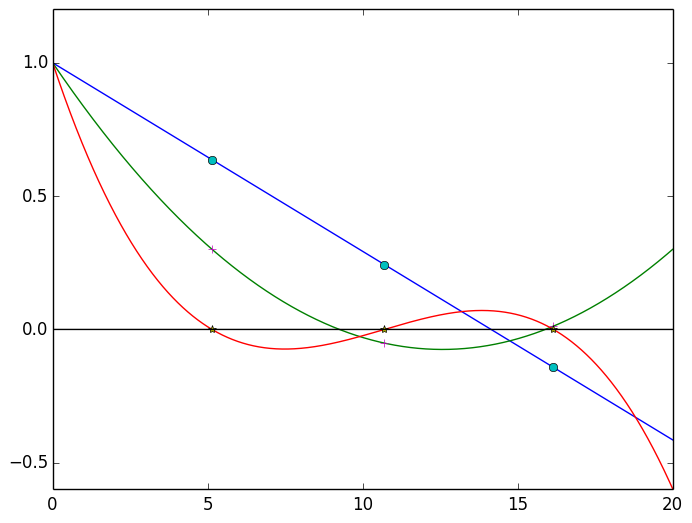

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.6.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:32
 in include_string at loading.jl:282
 in execute_request at /Users/michaelwathen/.julia/v0.4/IJulia/src/execute_request.jl:169
 in eventloop at /Users/michaelwathen/.julia/v0.4/IJulia/src/eventloop.jl:8
 in anonymous at task.jl:447
while loading In[3], in expression starting on line 26


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31b37ead0>

In [3]:
# small 3 x 3 problem
A=[7 3 1; 3 10 2; 1 2 15];
b=Array([28 31 22])';

eigA, vecA=eig(A);
r0=b; p0=b;
delta0=norm(r0)^2;
s0=A*p0;
alpha0=delta0/(p0'*s0)[1];
x1=zeros(3,1)+alpha0*p0;
r1=b-alpha0*s0;
delta1=norm(r1)^2;
p1=r1+delta1/delta0*p0;
s1=A*p1;
alpha1=delta1/(p1'*s1)[1];
x2=x1+alpha1*p1;

r2=r1-alpha1*s1;
delta2=norm(r2)^2;
p2=r2+delta2/delta1*p1;
s2=A*p2;
alpha2=delta2/(p2'*s2)[1]
x3=x2+alpha2*p2


x=[0:.01:20];

# p1:
c10=1;
c11=-alpha0;
p1=c10+c11*x;

# p2:
c20 = 1                                      # const (always 1)
c21 = -(alpha0+alpha1+alpha1*delta1/delta0)  # coef of x
c22 = alpha0*alpha1                          # coef of x^2
p2=c20+c21*x+c22*x.^2;

# p3:
c30 = 1;
c31 = -alpha0-alpha1*(1+delta1/delta0)-alpha2*(1+delta2/delta0+delta2/delta1);
c32 = alpha0*alpha1+alpha2*(alpha0+alpha1+alpha1*delta1/delta0)+alpha0*alpha2*delta2/delta1;
c33=-alpha0*alpha1*alpha2    # should be equal to: -1/(-eigA(1)*eigA(2)*eigA(3));
p3=c30+c31*x+c32*x.^2+c33*x.^3;
# Can also do this and then we are sure we're OK...
p33=(x-eigA[1]).*(x-eigA[2]).*(x-eigA[3])#/(-eigA[1]*eigA[2]*eigA[3]);

xx=eigA;
p1_eig=c10+c11*xx;
p2_eig=c20+c21*xx+c22*xx.^2;
p3_eig=c30+c31*xx+c32*xx.^2+c33*xx.^3;

plot(x,p1);
plot(x,p2);
plot(x,p3)
plot(xx,p1_eig,"o")
plot(xx,p2_eig,"+")
plot(xx,p3_eig,"*")
plot(x, 0*x, "k")

Example 7.17 Figure 7.11 : Poisson on a square using CG, PCG/multigrid.
Try a few grids and watch iteration count and timing

 in depwarn at deprecated.jl:73
 in int at deprecated.jl:50
 in poismg at In[4]:44
 [inlined code] from In[4]:131
 in anonymous at no file:0
 in include_string at loading.jl:282
 in execute_request at /Users/michaelwathen/.julia/v0.4/IJulia/src/execute_request.jl:169
 in eventloop at /Users/michaelwathen/.julia/v0.4/IJulia/src/eventloop.jl:8
 in anonymous at task.jl:447
while loading In[4], in expression starting on line 114
 in depwarn at deprecated.jl:73
 in int at deprecated.jl:50
 in poismg at In[4]:44
 in poismg at In[4]:48
 [inlined code] from In[4]:131
 in anonymous at no file:0
 in include_string at loading.jl:282
 in execute_request at /Users/michaelwathen/.julia/v0.4/IJulia/src/execute_request.jl:169
 in eventloop at /Users/michaelwathen/.julia/v0.4/IJulia/src/eventloop.jl:8
 in anonymous at task.jl:447
while loading In[4], in expression starting on line 114
 in depwarn at deprecated.jl:73
 in int at deprecated.jl:50
 in poismg at In[4]:44
 [inlined code] from In[4]:131
 in a

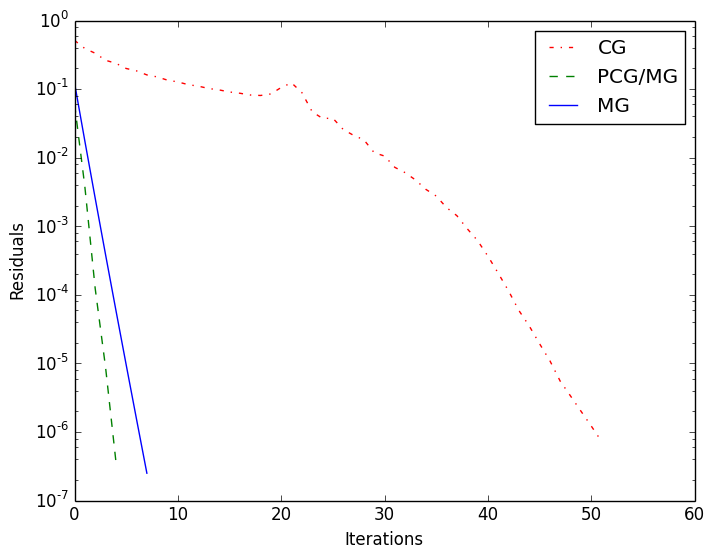

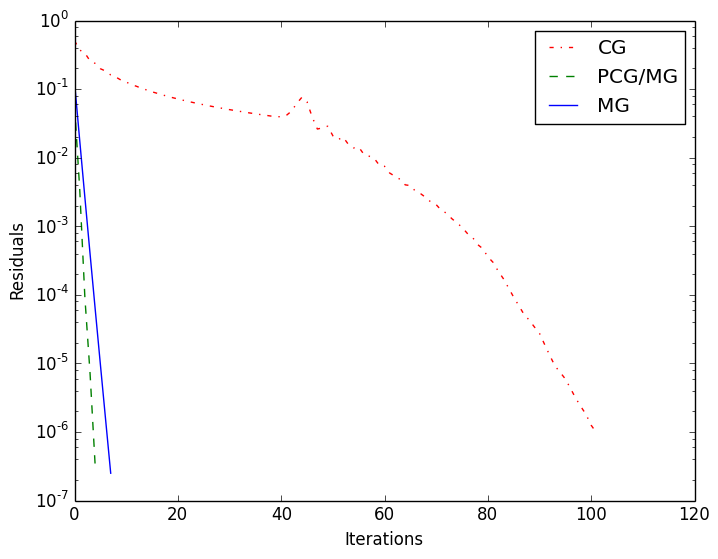

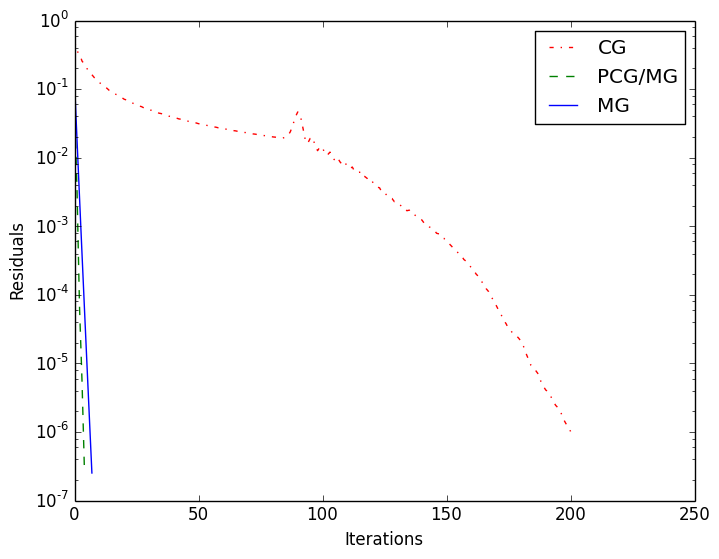

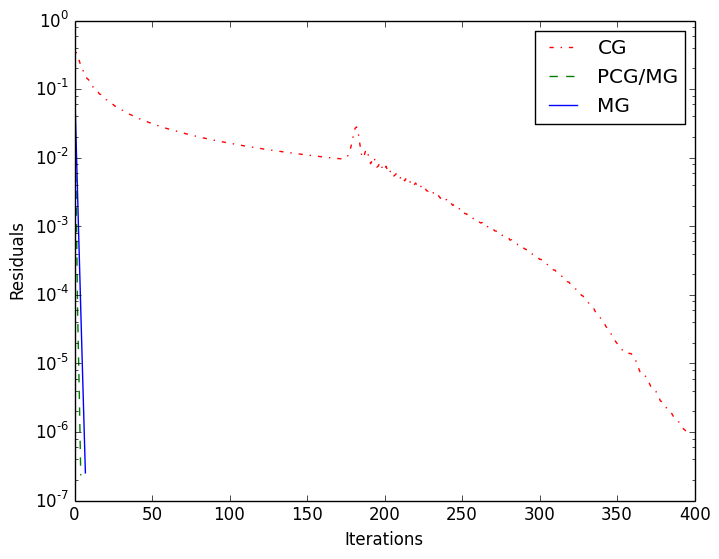

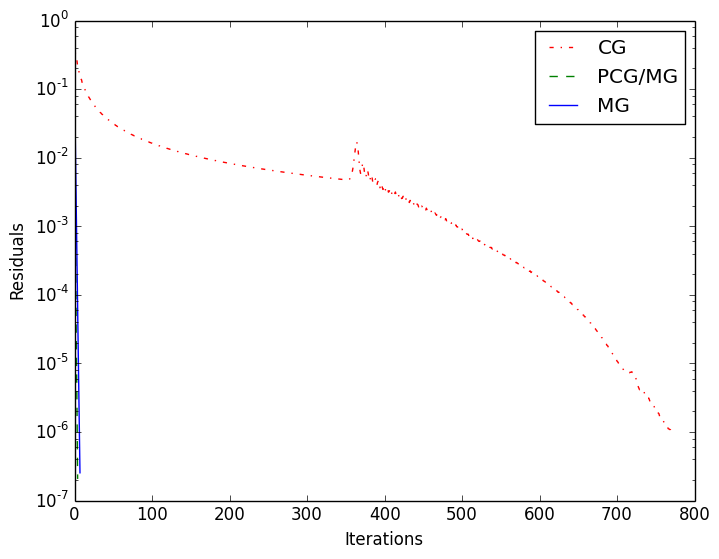

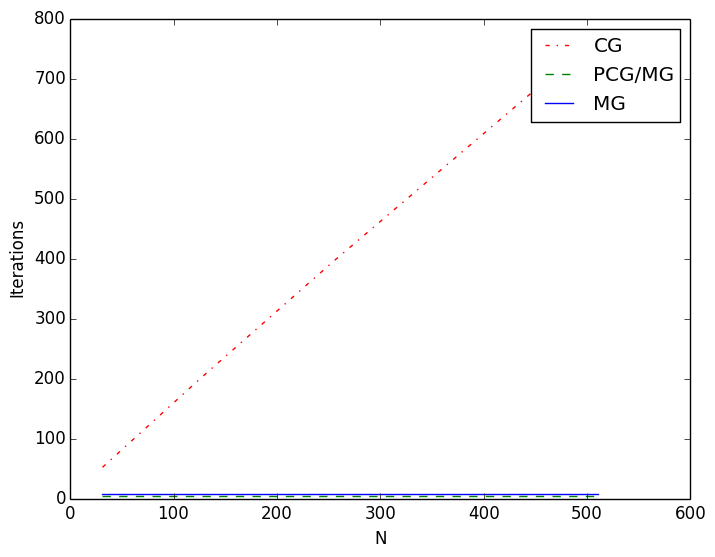

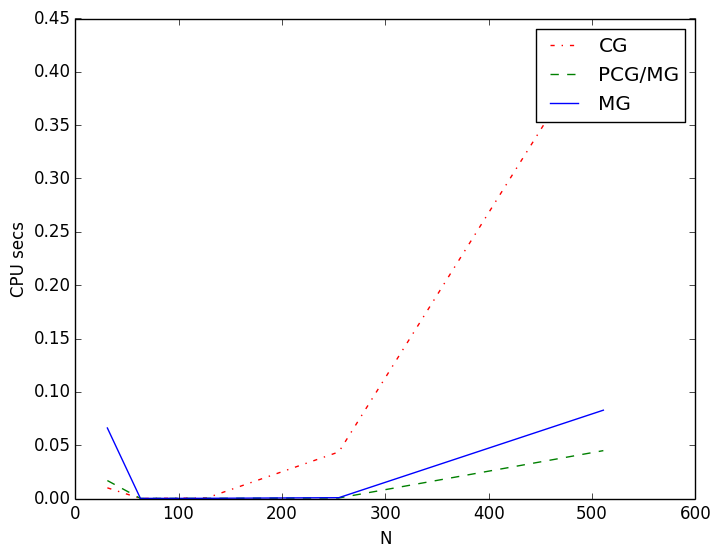

(5,)(1,5)


PyObject <matplotlib.text.Text object at 0x31bba1350>

In [4]:
function Laplacian(N)
    x1 = ones(N)
    x2 = ones(N-1)
    A = 2*spdiagm(x1, 0) -  spdiagm(x2, -1, N, N) - spdiagm(x2, 1, N, N)
    return kron(speye(N), A) + kron(A, speye(N))
end

function poismg(A,b,x,level)

    # function [x,res] = poismg(A,b,x,level)

    # multigrid V-cycle to solve simplest Poisson on a square
    # The uniform grid is N by N, N = 2^l-1 some l > 2,
    # b is the right hand side; homogeneous Dirichlet;
    # A has been created by   A = delsq(numgrid('S',N+2));

    coarsest = 2;              # coarsest grid
    nu1 = 2;                   # relaxations before coarsening grid
    nu2 = 2;                   # relaxations after return to finer level
    omeg = .8;                 # relaxation damping parameter
    if level == coarsest
        x = A\b;               # solve exactly on coarsest level
        r = b - A*x;

    else # begin multigrid cycle

        # relax using damped Jacobi
        Dv = diag(A);         # diagonal part of A as vector
        for i=1:nu1
          r = b - A*x;
          x = x + omeg*r./Dv;
        end

        # restrict residual from r to rc on coarser grid
        r = b - A*x; 
        N = round(Int,sqrt(length(b)));

        r = reshape(r,N,N);
        Nc = (N+1)/2 - 1; nc = Nc^2;    # coarser grid dimensions
        Ac = Laplacian(round(Int,Nc));  # coarser grid operator
            rc = r[2:2:N-1,2:2:N-1] + .5*(r[3:2:N,2:2:N-1] + r[1:2:N-2,2:2:N-1] + 
            r[2:2:N-1,3:2:N]+r[2:2:N-1,1:2:N-2]) + .25*(r[3:2:N,3:2:N] + 
            r[3:2:N,1:2:N-2]+r[1:2:N-2,3:2:N]+r[1:2:N-2,1:2:N-2]);
        rc = reshape(rc,int(nc),1);

        # descend level. Use V-cycle
        vc = zeros(size(rc));            # initialize correction to 0
        vc, res = poismg(Ac,rc,vc,level-1); # samesame on coarser grid

        # prolongate correction from vc to v on finer grid
        v = zeros(N,N);
        vc = reshape(vc,round(Int, Nc),round(Int, Nc));
        v[2:2:N-1,2:2:N-1] = vc;
        vz = zeros(N+2,N+2)
        vz[2:N+1,2:N+1] = v;
        v[1:2:N,2:2:N-1] = .5*(vz[1:2:N,3:2:N]+vz[3:2:N+2,3:2:N]);
        v[2:2:N-1,1:2:N] = .5*(vz[3:2:N,1:2:N]+vz[3:2:N,3:2:N+2]);
        v[1:2:N,1:2:N] = .25*(vz[1:2:N,1:2:N]+vz[1:2:N,3:2:N+2] + 
        vz[3:2:N+2,3:2:N+2]+vz[3:2:N+2,1:2:N]);

        # add to current solution
        n = N^2;
        x = x + reshape(v,n,1);

        # relax using damped Jacobi
        for i=1:nu2
          r = b - A*x;
          x = x + omeg*r./Dv;
        end

    end

    res = norm(b - A*x)
    return x, res
end

function pcgmg(A,b,x0,tol, maxit)
# 
#  function [x,iter,res] = pcgmg (A,b,x0,tol)
#  
#  CG with V-cycle preconditioning; assume x0=0

    N = sqrt(length(b));
    flevel = round(Int, log2(N+1));
    tol2 = tol^2;
    x = x0;
    r = b - A*x0;
    h, kk = poismg(A,r,x0,flevel);
    d = r'*h; bb = d;
    p = h;
    res = [];
    iter = 0;
    while tol2*bb[1] < d[1]
        d0 = d;
        s = A*p;
        alfa = d[1] / (p'*s)[1];
        x = x + alfa*p;
        r = r - alfa*s;
        h, kk = poismg(A,r,x0,flevel);
        d = r'*h;
        p = h + d[1]/d0[1]*p;
        iter = iter + 1;
        push!(res, norm(r));
        if iter > maxit
            break
        end
    end
    return x,iter,res
end

Ns = zeros(5) 
time = zeros(3,5)
itns = zeros(3,5)
for l = 5:9
    N = 2^l - 1;
    Ns[l-4] = N;  # save for plotting
    tol = 1.e-6;  # should actually depend on N but never mind.
    A = Laplacian(N)
    
    n = size(A,1);
    b = A*ones(n);
    coarsest = 1;
    # Solve using multigrid
    tic()
    CPUtic();
    xmg = zeros(n); bb = norm(b);
    flevel = round(Int,log2(N+1));
    rmg = []
    itmg = 0
    for itermg = 1:2000
        x, d = poismg(A,b,xmg,flevel);

        push!(rmg, norm(A*x-b))
        itmg = itmg + 1;
        if rmg[itermg]/bb < tol
            break
        end
        xmg = x
    end
    time[1,l-4] = toq() - CPUtoq(); 
    itns[1,l-4] = itmg; 
    
    # preconditioned CG with V-cycle
    tic()
    CPUtic();
    x0 = zeros(n);
    xcgmg,itercgmg,rcgmg = pcgmg(A,b,x0,tol, 2000);
    time[3,l-4] = toq() - CPUtoq();
    itns[3,l-4] = itercgmg;
    
    # CG straight
    tic()
    CPUtic();
    xCG,chCG = cg(A,b;tol=tol, maxiter=2000);
    rCG = chCG.residuals/norm(b);
    time[2,l-4] = toq() - CPUtoq();
    itns[2,l-4] = length(chCG.residuals);

    figure()
    semilogy(rCG,"r-.",label="CG")
    semilogy(rcgmg/norm(b),"g--", label="PCG/MG")
    semilogy(rmg/norm(b),"b", label="MG")
    legend()
    xlabel("Iterations")
    ylabel("Residuals")
  
end
println(size(Ns),size(itns[2,:]))
# Plot relative residuals  
figure()
plot(Ns,itns[2,:]',"r-.",label="CG")
plot(Ns,itns[3,:]',"g--",label="PCG/MG")
plot(Ns,itns[1,:]',"b",label="MG")
legend()
ylabel("Iterations")
xlabel("N")

figure()
plot(Ns,time[2,:]',"r-.",label="CG")
plot(Ns,time[3,:]',"g--",label="PCG/MG")
plot(Ns,time[1,:]',"b",label="MG")
legend()
ylabel("CPU secs")
xlabel("N")

Comparison of methods for Poisson model problems

In [ ]:
function Laplacian(N)
    x1 = ones(N)
    x2 = ones(N-1)
    A = 2*spdiagm(x1, 0) -  spdiagm(x2, -1, N, N) - spdiagm(x2, 1, N, N)
    return kron(speye(N), A) + kron(A, speye(N))
end

N = 31;
tol = 1.e-6;

# build linear system
A = Laplacian(N)
n = size(A,1);
b = A*ones(n);

Dv = diag(A);         # diagonal part of A as vector
D = spdiagm(Dv);         # diagonal part of A as matrix
E = tril(A);          # lower triangular part of A
omega = 1+cos(pi/(N+1))/(1+sin(pi/(N+1)))^2; # for SOR
Eomega = ((1-omega)*D + omega*E)/omega;      # for SOR
# Jacobi
rJ = []; r = b; x = 0*b; 
for i=1:10000
    x = x + r./Dv;
    r = b - A*x;
    push!(rJ, norm(r)/norm(b));
    if rJ[i] < tol
        break
    end
end
xJ = x;
# Gauss Seidel
rGS = []; x = zeros(n); r = b;
for i=1:10000
    x = x + E \ r;
    r = b - A*x;
    push!(rGS, norm(r)/norm(b));
    if rGS[i] < tol
        break
    end
end
xGS = x;

# SOR
rSOR = []; x = zeros(n); r = b;
for i=1:10000
    x = x + Eomega \ r;
    r = b - A*x;
    push!(rSOR, norm(r)/norm(b));
    if rSOR[i] < tol
        break
    end
end
xSOR = x;

# Conjugate gradient, using Julia's builtin routines
tic()
CPUtic();
xCG,chCG = cg(A,b;tol=tol, maxiter=2000);
cgtime = toq() - CPUtoq();
rCG = chCG.residuals/norm(b);

# Plot relative residuals
figure()
semilogy(rJ,"m", label="Jacobi")
semilogy(rGS,"r-.", label="Gauss-Seidel")
semilogy(rSOR,"--", label="SOR")
semilogy(rCG, label="CG")
legend()
xlabel("Iterations")
ylabel("Residual norm")


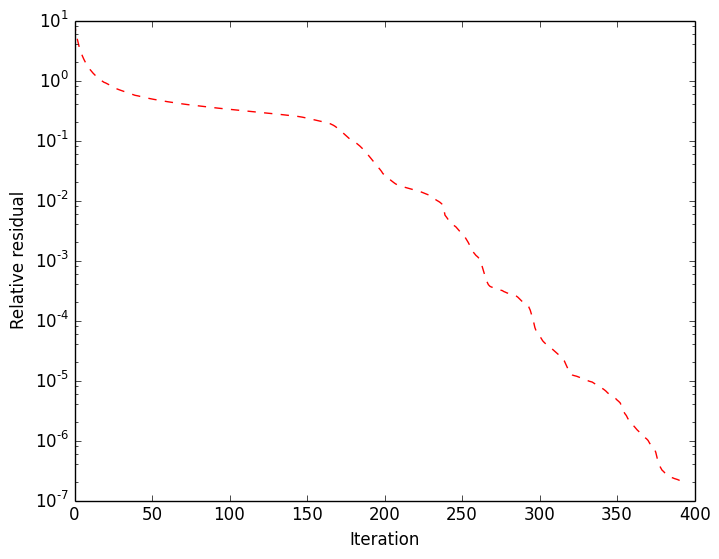

PyObject <matplotlib.text.Text object at 0x323ecec90>

In [68]:
# Example 7.13 -- Figure 7.8 : convection-diffusion equation

# problem parameters
beta=.1; gamma=.1;

N=100; x1 = ones(N); x2 = ones(N-1)

# set up linear system matrix A
a=4; b=-1-gamma; c=-1-beta; d=-1+beta; e=-1+gamma;
t1= a*spdiagm(x1, 0) +  c*spdiagm(x2, -1, N, N) + d*spdiagm(x2, 1, N, N)
t2= b*spdiagm(x2, -1, N, N) + e*spdiagm(x2, 1, N, N)
A=kron(speye(N),t1)+kron(t2,speye(N));

b=A*ones(10000);
r = 20
x, ch = gmres(A,b; tol=1e-8, maxiter=2000, restart = r);
resvec = ch.residuals
r = []
for i = 1:20
    append!(r, resvec[i, :][:])
end
# println(reshape(resvec,400,1))
semilogy(r,"--r")#, label="non-preconditioned GMRES")
legend();
xlabel("Iteration")
ylabel("Relative residual")